In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
!pwd
!ls

/content/drive/MyDrive
 AirQualityUCI1.csv	    go1220031104.fits
 air_quality_uci2.parquet   hotel_bookings_training.csv
 air_quality_uci3.parquet   inference_pipeline.joblib
 AirQualityUCI.csv	    new_customers.csv
'Colab Notebooks'	    __pycache__
 correlación.png	    transaction_dataset_clean.csv
 Data.csv		    transaction_dataset.csv
 Funciones.py		    videojuegos.csv
 go1020011213.fits


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, metrics, model_selection
from sklearn.neural_network import MLPClassifier

import time
#from matplotlib import pyplot as plt
from matplotlib import pylab as plt
from IPython import display

# Agregar el directorio de common_functions al path
sys.path.append(os.path.join(os.path.dirname(__file__), '..', '..', 'common_functions'))
from eval_functions import evaluar, evaluarDerivada

Cargamos el dataset limpio

In [ ]:
numeric_df3 = pd.read_csv('/content/drive/MyDrive/transaction_dataset_clean.csv')

numeric_df3

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 avg val sent,ERC20 uniq sent token name
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.000000,30.000000,54.000000,0.00000,58.000000,0.000000,1.500000e+07,2.655861e+05,2.717799e+05,39.000000
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,0.000000,1.000000,5.000000,0.00000,7.000000,0.000000,3.650000e+02,5.763262e+01,2.260809e+00,1.000000
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.000000,0.000000,7.000000,0.00000,8.000000,0.000000,4.428198e+02,6.518901e+01,0.000000e+00,0.000000
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,0.000000,2.000000,11.000000,0.00000,11.000000,0.000000,1.141223e+04,1.555550e+03,3.804077e+03,1.000000
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.000000,4.000000,23.000000,0.00000,27.000000,0.000000,9.000000e+04,4.934232e+03,1.372666e+04,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,1,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,...,0.000000,0.000000,2.000000,0.00000,2.000000,0.000000,1.337000e+00,6.685000e-01,0.000000e+00,0.000000
9837,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,...,0.000000,0.000000,1.000000,0.00000,1.000000,13.370000,1.337000e+01,1.337000e+01,0.000000e+00,0.000000
9838,1,2499.44,2189.29,261601.88,67,43,0,31,44,0.001078,...,0.000000,0.000000,5.000000,0.00000,5.000000,0.000000,1.500000e+03,3.006939e+02,0.000000e+00,0.000000
9839,1,0.00,0.00,0.00,0,1,0,1,0,0.500000,...,110.939207,5.638038,7.598535,0.00344,4.901909,485.614688,1.252524e+08,4.346203e+06,6.318389e+06,1.384931


In [ ]:
# Vamos a dividir el dataset entre el valor objetivo (sobre el cual se va a aplicar el SMOTE) y el resto de los atributos

X = numeric_df3.drop("FLAG", axis=1)                                   # Quita la columna FLAG del dataset

y = numeric_df3["FLAG"]                                                # Extrae la columna FLAG como la variable objetivo


Vamos a dvidir en datos de entrenamiento y datos de prueba:

In [ ]:
from sklearn.model_selection import train_test_split                   # Se usa para dividir el dataset en conjuntos de entrenamiento y prueba, manteniendo proporciones aleatorias

# Dividir en entrenamiento y prueba (sin SMOTE aún)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Armamos la estructura de la red neuronal: neuronas de entrada, oculta y salida.

In [ ]:
nFilas = len(X_train)+len(X_test)
#nFilas = len(X)
entradas = X.shape[1]
ocultas = 20

# La red tendrá una salida para cada tipo de fraude (fraude o no fraude)
salidas = len(np.unique(y))
print("Neuronas de entrada = %d ; Neuronas de salida = %d" % (entradas, salidas))

Neuronas de entrada = 32 ; Neuronas de salida = 2


Normalizamos los datos utilizando la media y desvío.

In [ ]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores restando la media y diviendiendo entre el desvió estandar
    standard_scaler = preprocessing.StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test)

y_trainB = np.zeros((len(y_train), salidas))                            # Armamos una matriz de zeros, en la cual van a ir 0 y 1, donde el 1 irá en la
for o in range(len(y_train)):                                           # posición de la clase, ej, si es tipo 1 ==> la fila será [0, 1], si es tipo 0
    y_trainB[o, y_train.iloc[o]]=1                                           # la fila será [1, 0], y así

print(y_train)
y_trainB

8460    1
6081    0
8966    1
1535    0
7304    0
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: FLAG, Length: 6888, dtype: int64


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Armamos las matrices de pesos y bias tanto para la capa de entrada a la oculta como para la capa oculta a la salida

In [ ]:
# Elijo las matrices de pesos y bias que van de la entrada a la capa oculta (w1 y b1) y los que van de la oculta a la salida (w2 y b2)

W1 = np.random.uniform(-1,1,[ocultas, entradas])                      # Elijo números aleatorios entre -1 y 1, y me queda una matriz de 20x38 (oculta, entrada)
b1 = np.random.uniform(-1,1, [ocultas,1])
W2 = np.random.uniform(-1,1,[salidas, ocultas])
b2 = np.random.uniform(-1,1, [salidas,1])

#dibuPtos_y_2Rectas(X,Y, W1, b1)

print(f"Como tengo {entradas} neuronas de entrada, {ocultas} ocultas y {salidas} de salida, para la primera parte de la red voy a tener {entradas*ocultas} arcos y para la segunda {ocultas*salidas}, haciendo un total de {entradas*ocultas+ocultas*salidas} arcos para la red")
W1

Como tengo 32 neuronas de entrada, 20 ocultas y 2 de salida, para la primera parte de la red voy a tener 640 arcos y para la segunda 40, haciendo un total de 680 arcos para la red


array([[ 5.42106980e-01, -6.16886004e-01,  9.45685270e-01,
        -3.29205199e-01, -7.76930692e-01,  7.98421856e-02,
         2.41571872e-01,  6.67172912e-01, -5.02010531e-01,
         8.33338483e-01, -9.26855694e-03, -1.73898858e-01,
        -4.45220044e-01, -2.29791134e-01, -6.14861162e-01,
         9.69019228e-01,  3.27911682e-01,  9.60704729e-01,
        -7.54540744e-01,  5.95781416e-01,  6.83592671e-01,
         1.15342283e-01, -2.91520128e-03, -5.91879584e-01,
         5.00213012e-01,  7.64224160e-01,  1.92721796e-01,
        -1.00780435e-02, -9.66801437e-01,  2.66308674e-01,
        -1.42632605e-01, -2.86392459e-01],
       [-7.00901283e-01,  3.15967953e-01, -9.80162102e-01,
        -6.16572128e-01, -2.38521525e-02,  4.23035319e-01,
        -3.32294515e-01, -4.98689007e-01,  6.00654688e-01,
        -3.99037178e-01,  6.69641306e-01, -1.73751827e-01,
         3.19575667e-01,  6.52255943e-01, -5.03506607e-01,
         1.15330873e-01, -8.28020204e-01, -3.50710592e-02,
         9.55

Definimos las funciones de activación. Las cuales son sumamente importante para poder encontrar relaciones o patrones no lineales entre los atributos del dataset, es decir permite introducir no linealidad en el modelo

In [ ]:
FunH = 'sigmoid'
FunO = 'tanh'

if (FunO=='tanh'):
    y_trainB = 2*y_trainB -1                            # Transforma los valores de salida de one-hot encoding de [0, 1] a [-1, 1]. Esto es importante si la
                                                        # función de activación de salida es tanh, porque tanh(x) siempre da valores en el rango (-1, 1)

Ciclo de entrenamiento de la red neuronal feedforward usando backpropagation con descenso del gradiente. Caractéristicas de la red:

Activaciones 'sigmoid' y 'tanh'

Aprendizaje estocástico

Criterio de parada basado en convergencia del error

In [ ]:
nFilas = X_train.shape[0]                                                  # Cantidad de ejemplos de entrenamiento

alfa = 0.1                                                                 # Tasa de aprendizaje (learning rate)
CotaError = 1.0e-4                                                         # Umbral mínimo de error para detener
MAX_ITERA = 400                                                            # Máx. cantidad de iteraciones permitidas
ite = 0                                                                    # Contador de iteraciones
errorAnt = 0                                                               # Error de la iteración anterior
AVGError = 1                                                               # Error promedio inicial (alto)
errores = []                                                               # Lista para guardar la evolución del error
ph=0
while ( abs(AVGError-errorAnt) > CotaError ) and ( ite < MAX_ITERA ):               # Repite el entrenamiento hasta que el cambio en el error promedio es pequeño (converge) o se alcanza el límite de iteraciones.
    errorAnt = AVGError
    AVGError = 0
    for e in range(nFilas):  # para cada ejemplo, es decir, se actualiza la red ejemplo por ejemplo

        xi = X_train[e:e+1, :]      # ejemplo a ingresar a la red
        yi = y_trainB[e:e+1, :]     # salida esperada para el ejemplo seleccionado

        # propagar el ejemplo hacia adelante
        netasH = W1 @ xi.T + b1                  # Entrada a la capa oculta
        salidasH = evaluar(FunH, netasH)         # Salida de la capa oculta
        netasO = W2 @ salidasH + b2              # Entrada a la capa de salida
        salidasO = evaluar(FunO, netasO)         # Salida de la red

        # calcular los errores en ambas capas
        ErrorSalida = yi.T-salidasO                  # Diferencia entre la salida deseada (yi) y la salida real


        # Calcular los deltas o gradientes locales de error para cada capa, usando la derivada de la función de activación. Es la parte clave del algoritmo de backpropagation
        deltaO = ErrorSalida * evaluarDerivada(FunO,salidasO)
        deltaH = evaluarDerivada(FunH,salidasH)*(W2.T @ deltaO)

        # corregir todos los pesos según los deltas calculados
        W1 = W1 + alfa * deltaH @ xi
        b1 = b1 + alfa * deltaH
        W2 = W2 + alfa * deltaO @ salidasH.T
        b2 = b2 + alfa * deltaO

        AVGError = AVGError + np.mean(ErrorSalida**2)           # Se va acumulando el error cuadrático medio por ejemplo

    # Se promedia el error total y se guarda para graficar o monitorear la evolución
    AVGError = AVGError / nFilas
    errores.append(AVGError)

    ite = ite + 1

/content/drive/MyDrive/Funciones.py:10: RuntimeWarning: overflow encountered in exp
  return (1.0/(1+np.exp(np.dot(-1,x))))


Gráfico del error

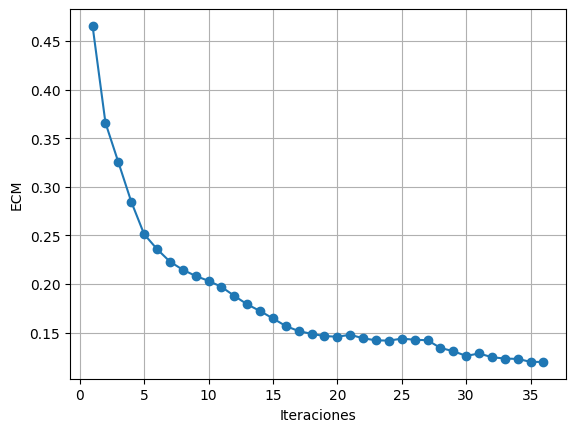

0.11994628832473933


In [ ]:
plt.plot(range(1, len(errores) + 1), errores, marker='o')      # En el eje x va el n° de iteraciones, lo hacemos tomando un rango desde 1 hasta la long de errores (el +1 es porque range no toma el límete superior)
plt.xlabel('Iteraciones')
plt.ylabel('ECM')
plt.grid(True)
plt.show()

print(min(errores))

In [ ]:
# Respuesta de la red para los datos de ENTRENAMIENTO, es decir, los pesos y bias óptimos para el entrenamiento de acuero a lo que aprendió la red

NetasH = W1 @ X_train.T + b1                          # Calcula las entradas netas de las neuronas ocultas.
SalidasH = evaluar(FunH, NetasH)                      # salidas de la capa oculta.
NetasO = W2 @ SalidasH + b2                           # Calcula las entradas netas de las neuronas de salida.
SalidasO = evaluar(FunO, NetasO)                      # salidas de la capa de salida.

SalidasO[:, :5]

array([[-0.9804788 ,  0.90693768, -0.9716321 ,  1.        ,  0.99511217],
       [ 0.98057329, -0.91367791,  0.96758949, -1.        , -0.99504014]])

Porcentaje de aciertos del entrenamineto

In [ ]:
y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_train : %.3f" % metrics.accuracy_score(y_train,y_pred))

% aciertos X_train : 0.967


Generemos un informe completo de métricas de clasificación usando las verdaderas (y_train) y las predichas (y_pred) clases.

Este informe incluye para cada clase:

precision: qué proporción de las predicciones para esa clase fueron correctas.

recall (sensibilidad): qué proporción de los verdaderos ejemplos de esa clase fueron bien clasificados.

f1-score: el promedio armónico de precisión y recall.

support: cuántos ejemplos reales había de esa clase.

In [ ]:
report = metrics.classification_report(y_train,y_pred)
print("Informe de métricas:\n%s" % report)

Informe de métricas:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5359
           1       0.93      0.93      0.93      1529

    accuracy                           0.97      6888
   macro avg       0.95      0.95      0.95      6888
weighted avg       0.97      0.97      0.97      6888



In [ ]:
MM = metrics.confusion_matrix(y_train,y_pred)
print("Confusion matrix:\n%s" % MM)

# Calcular e imprimir aciertos y errores por clase
print("\nAciertos y errores por clase:")
num_clases = MM.shape[0]

for i in range(num_clases):
    aciertos = MM[i, i]
    errores = sum(MM[i, :]) - aciertos
    print(f"Clase {i}: Aciertos = {aciertos}, Errores = {errores}")

Confusion matrix:
[[5244  115]
 [ 110 1419]]

Aciertos y errores por clase:
Clase 0: Aciertos = 5244, Errores = 115
Clase 1: Aciertos = 1419, Errores = 110


In [ ]:
# -- TESTING ---
NetasH = W1 @ X_test.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)

y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_test : %.3f\n" % metrics.accuracy_score(y_test,y_pred))

report = metrics.classification_report((y_test),(y_pred))
print("Confusion matrix Test:\n%s" % report)

MM = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % MM)

print('\n------Si usamos la normalización lineal, el acierto es de',metrics.accuracy_score(y_test,y_pred))

% aciertos X_test : 0.957

Confusion matrix Test:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2303
           1       0.91      0.90      0.90       650

    accuracy                           0.96      2953
   macro avg       0.94      0.94      0.94      2953
weighted avg       0.96      0.96      0.96      2953

Confusion matrix:
[[2243   60]
 [  66  584]]

------Si usamos la normalización lineal, el acierto es de 0.9573315272604132


/content/drive/MyDrive/Funciones.py:10: RuntimeWarning: overflow encountered in exp
  return (1.0/(1+np.exp(np.dot(-1,x))))


**Características sin el oversampling**

La diferencia entre el accuracy de entrenamiento (0.966) y prueba (0.957) es muy pequeña. Esto indica que el modelo NO está sobreajustado (overfitting) NI subajustado (underfitting). En otras palabras, el modelo generaliza bien a datos nuevos.

Un accuracy del 95.7% en datos de prueba sugiere que el modelo hace predicciones correctas para una gran mayoría de los casos. Esto es un indicador de que el modelo tiene un buen desempeño global.

**1) Métricas clave para cada clase**

**Clase 0 (no fraude):**

**-Precision:** 0.97, El 97% de los registros que el modelo predijo como "no fraude" fueron correctos.

**-Recall:** 0.97, El modelo detectó el 97% de todos los registros reales de "no fraude".

**-F1-Score:** 0.97, Excelente balance entre precisión y recall en esta clase.

**Clase 1 (fraude):**

**-Precisión:** 0.91, El 91% de los registros predichos como "fraude" son correctos.

**-Recall:** 0.90, El modelo detectó el 90% de los fraudes reales.

**-F1-Score:** 0.90, Buen balance entre precisión y recall, especialmente considerando que detectar fraudes es la prioridad.

**2) Evaluación general del modelo**

**-Accuracy:** 0.96, El modelo clasifica correctamente el 96% de los casos totales. Esto es muy bueno, pero en datasets desbalanceados el accuracy puede ser engañoso.

**-Macro avg (media de las métricas para ambas clases, sin considerar el tamaño de cada clase):** - Precision: 0.94 Recall: 0.94 F1-Score: 0.94. Buen desempeño para ambas clases.

**-Weighted avg (media ponderada según el tamaño de cada clase):** Precision: 0.96 Recall: 0.96 F1-Score: 0.96. Este valor refleja el desempeño general del modelo, considerando que la clase mayoritaria (no fraude) domina.

**3) Análisis y observaciones**

**-detectando fraudes (clase 1):** Recall de 0.90: El modelo identifica la mayoría de los fraudes, lo que es crucial en este problema. Sin embargo, el 10% de los fraudes no fueron detectados. Dependiendo del contexto, esto podría ser un área de mejora si se busca minimizar falsos negativos (fraudes no detectados).

**-Precisión en fraudes (Clase 1):** Precision de 0.91: Esto significa que el modelo mantiene un buen control sobre los falsos positivos (casos que clasifica como fraude pero no lo son)

**- Calse 0 (no fraude)** El modelo tiene excelente desempeño en no fraudes, lo cual es esperado dado que hay más datos representativos de esta clase.

**- Balance entre clases** El macro avg (0.94 en F1-Score) sugiere que el modelo trata bien ambas clases, pero un recall más alto para fraudes podría mejorarse.

**4) Conclusiones** Definitivamente es un buen clasificador, pero se lo puede mejorar, y más aún si se quiere detectar la mayor cantidad de fraudes, habría que aumentar el recall de la clase 1 y que sea más parejo al resto de las métricas o incluso al mismo recall de la clase 0

**Características con oversampling**

Se aplicó la SMOTE después de la división de los datos, cosa que solo se aplique sobre los datos de entrenamiento. El dataset quedó un 60/40.

Los accuracy rondan entre el 45 y 60%, un modelo bastante malo. Todas las métricas están en el orden del accuracy, sin embargo el recall de la clase 1 (fraude) es 0.99, prácticamente lo único positivo del oversampling.

la precision y el accuracy general se deterioran porque el modelo clasifica demasiados casos como fraude, generando más falsos positivos.

Quizás la causa se deba a que la distribución real de la clase minoritaria (clase 1, fraude) es irregular o tiene patrones únicos, por lo que los datos sintéticos podrían no representar adecuadamente esta clase, lo que afecta la capacidad del modelo de generalizar bien en el conjunto de prueba.